# Lab 6

## Author: Yakovlev Konstantin

### Description

Repeat sampling procedure from [paper](https://arxiv.org/abs/1211.4246). Compare sampling with SGLD procedure.

### Theory

__Theorem 1__ Let $p(x)$ be the probability density function of the data. If we train a Denoising Auto Encoder using the expected quadratic loss and corruption noise $N(x) = x + \sigma\varepsilon$ with $\varepsilon \sim \mathcal{N}(0, 1)$, then the optimal reconstruction $r_\sigma^*(x) = g(f(x))$ behaves assimptotically:

$$r_\sigma^*(x) = x + \sigma^2\frac{\partial\log p(x)}{\partial x} + o(\sigma^2), \quad \sigma \to 0.$$

__Sampling procedure__

Given a learned score function $\nabla_x\log p(x)$. We use Metropolis-Hastings algorithm with a proposed distribution $q(x^*|x) = \mathcal{N}(x^*|x, \sigma_{MH}^2I)$.

Acceptance rate is calculated as follows $A = \exp(E(x) - E(x^*))$,
where energy $E(x)$ cannot be calculated, because we do not know a normalizing constant. Fortunatelly, we can approximate energy difference, as we have learned a score function: $\nabla\log p(x) = -\nabla_xE(x)$:

$$E(x^*) - E(x) = \int_0^1\nabla_x E(\gamma(t))d\gamma(t),$$
where $\gamma(.)$ is a smooth curve between $x$ and $x^*$. Let $\gamma(.)$ be a cut between $x$ and $x^*$, so we aproximate the intergal with Simpson's 1/3 rule (not stated in the paper).

__Experimantal setup__

1. Encoder and decoder are MLP with ReLU activations.

2. Synthetic 2-D dataset.

3. We compare the proposed procedure with SGLD.

In [29]:
! pip install -q jax jaxlib flax optax

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
from functools import partial
from flax import linen as nn
from sklearn.datasets import make_moons, make_blobs

from typing import Sequence
import optax

### Model

In [16]:
class MLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

class AutoEncoder(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.enc = MLP(self.features)
        self.dec = MLP(self.features[::-1])
    
    def __call__(self, x):
        return self.dec(self.enc(x))


In [18]:
@partial(jax.jit, static_argnums=0)
def loss(apply_fn, params, x, x_noised, sigma):
    r = lambda x: apply_fn(params, x)
    # def jacob(y):
    #     return (jax.jacfwd(r)(y) ** 2).sum()

    rec_loss = ((r(x_noised) - x) ** 2).sum(-1).mean()
    # jacob_loss = jax.vmap(jacob)(x)
    return rec_loss# + (sigma ** 2) * jacob_loss.mean()

### Dataset

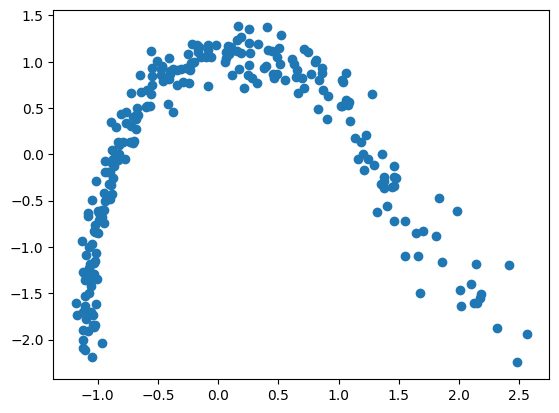

In [31]:
M = 2
N = 250
np.random.seed(0)

# Helix
T = np.sqrt(np.linspace(1, 10, N))
theta = np.linspace(0, 0.5 * 2 * np.pi, N)[..., None]
X = np.random.randn(N, M) * 0.05 + np.concatenate([np.cos(theta), np.sin(theta)], axis=-1)
X /= T[..., None]

X = (X - X.mean(axis=0)[None]) / X.std(axis=0)[None]
x, y = X[:, 0], X[:, 1]
plt.scatter(x, y)
plt.show()

## Train DAE

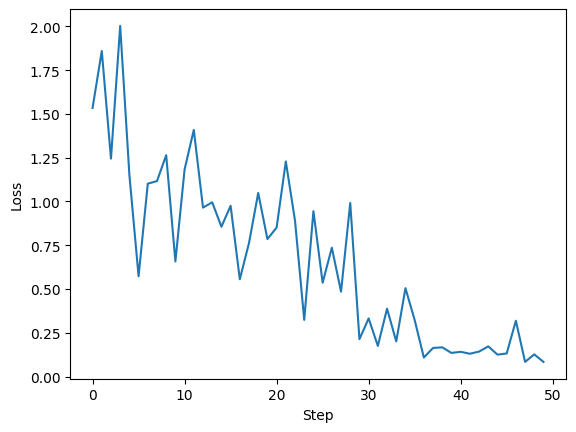

In [33]:
batch_size = 32
opt = optax.adam(1e-2)
ae = AutoEncoder([M, 6, 1])
key = jax.random.PRNGKey(0)
params = ae.init(key, jnp.zeros(shape=(16, M)))
opt_state = opt.init(params)
sigma = 0.1
losses = []

X_train = X


@partial(jax.jit, static_argnums=0)
def value_and_grad(apply_fn, params, x, x_noised, sigma):
    l, grads = jax.value_and_grad(lambda p: loss(apply_fn, p, x, x_noised, sigma))(params)
    return l, grads

@jax.jit
def update(opt_state, grads, params):
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

np.random.seed(0)
for i in range(500):
    ids = np.random.choice(X_train.shape[0], size=(batch_size,), replace=False)
    x_noised = jnp.asarray(X_train[ids] + np.random.randn(*X_train[ids].shape) * sigma)
    x = jnp.asarray(X_train[ids])
    l, grads = value_and_grad(ae.apply, params, x, x_noised, sigma)
    losses.append(l.item())
    opt_state, params = update(opt_state, grads, params)

plt.plot(losses[::10])
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

### SGLD procedure

In [35]:
def score_fn(apply_fn, params, x, sigma):
    return (apply_fn(params, x) - x) / (sigma ** 2)

In [36]:
@partial(jax.jit, static_argnums=0)
def sgld_step(apply_fn, params, x, sigma, key, eps):
    g = score_fn(apply_fn, params, x, sigma)
    # g = true_score(x)
    eta = jax.random.normal(key, shape=x.shape) * jnp.sqrt(eps)
    return x + eps / 2 * g + eta

# SGLD
x = jnp.zeros(shape=(1, M))
x_arr = [np.array(x)]
key = jax.random.PRNGKey(0)
for _ in range(10_000):
    x = sgld_step(ae.apply, params, x, sigma, key, 3e-2)
    key, _ = jax.random.split(key)
    x_arr.append(np.array(x))
x_arr = np.concatenate(x_arr, axis=0)

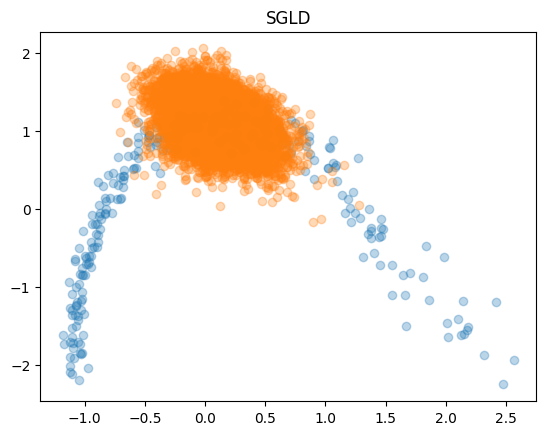

In [39]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
x, y = x_arr[:, 0], x_arr[:, 1]
plt.scatter(x[100:], y[100:], alpha=0.3)
plt.title('SGLD')
plt.show()

In [40]:
@partial(jax.jit, static_argnums=0)
def mh_step(apply_fn, params, x, sigma, key, eps):
    x_star = x + jax.random.normal(key, shape=x.shape) * eps
    # E(x) - E(x*)
    # Simpson's rule
    delta_E = 1/6 * (score_fn(apply_fn, params, x, sigma) + \
                     score_fn(apply_fn, params, x_star, sigma) + \
                     4 * score_fn(apply_fn, params, (x + x_star) / 2, sigma)
                     ).reshape(-1) @ (x_star - x).reshape(-1)

    acc_rate = jnp.exp(delta_E)
    
    return acc_rate, x_star

# Metropolis Hastings
x = jnp.zeros(shape=(1, M))
x_arr = [np.array(x)]
acc_rates = []
key = jax.random.PRNGKey(0)
np.random.seed(0)
for _ in range(10_000):
    acc_rate, x_star = mh_step(ae.apply, params, x, sigma, key, 3e-1)
    key, _ = jax.random.split(key)
    acc_rates.append(min(1, acc_rate.item()))
    if np.random.rand() <= min(acc_rate.item(), 1):
        x = x_star
        x_arr.append(np.array(x))
x_arr = np.concatenate(x_arr, axis=0)

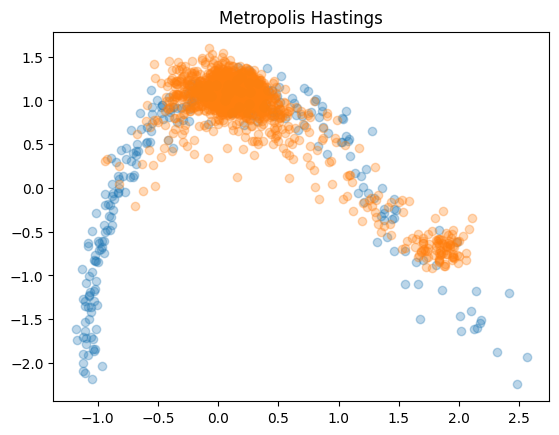

In [42]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
x, y = x_arr[:, 0], x_arr[:, 1]
plt.scatter(x[100:], y[100:], alpha=0.3)
plt.title('Metropolis Hastings')
plt.show()

In [43]:
np.mean(acc_rates)

0.20733829144784344

## Conclusion

The proposed Metropolis Hastings procedure captures the geometry of the data distribution. On the other hand, SGLD traverses the mode of the distribution witout capturing the curvature.